# AutoEncoder model 

### Loading the dataset

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import numpy as np

In [17]:
def multiple_plotting(str1, str2, str3, str4):
    # 파일 경로, 이름 설정해주세요.
    data1_df = pd.read_csv(str1, header=None)
    data2_df = pd.read_csv(str2, header=None)
    data3_df = pd.read_csv(str3, header=None)
    data4_df = pd.read_csv(str4, header=None)

    data1_df.columns = ['x', 'y', 'z']
    data2_df.columns = ['x', 'y', 'z']
    data3_df.columns = ['x', 'y', 'z']
    data4_df.columns = ['x', 'y', 'z']


    vector_value1 = np.sqrt(data1_df['x']** 2 + data1_df['y']**2 + data1_df['z']**2)
    vector_value2 = np.sqrt(data2_df['x']** 2 + data2_df['y']**2 + data2_df['z']**2)
    vector_value3 = np.sqrt(data3_df['x']** 2 + data3_df['y']**2 + data3_df['z']**2)
    vector_value4 = np.sqrt(data4_df['x']** 2 + data4_df['y']**2 + data4_df['z']**2)

    plt.figure(figsize=(20,20))
    fig, axes = plt.subplots(nrows=2, ncols=2)

    axes[0][0].plot(vector_value1)
    axes[0][1].plot(vector_value2)
    axes[1][0].plot(vector_value3)
    axes[1][1].plot(vector_value4)

    for ax in axes.flatten():
        ax.set_ylim(0.6, 1.4)
    plt.show()

<Figure size 2000x2000 with 0 Axes>

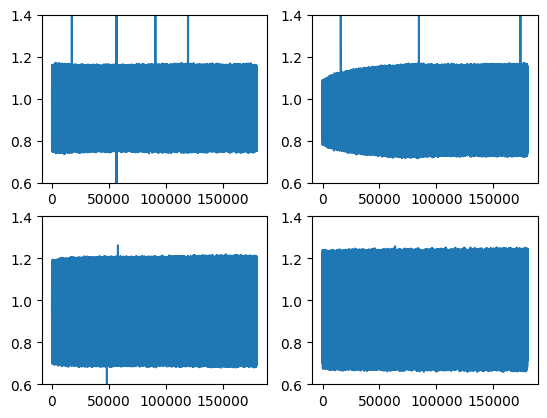

In [4]:
multiple_plotting()

In [6]:
data1_df = pd.read_csv('data/normal_9v_data.csv', header=None)
data2_df = pd.read_csv('data/normal_10v_data.csv', header=None)
data3_df = pd.read_csv('data/normal_11v_data.csv', header=None)
data4_df = pd.read_csv('data/normal_12v_data.csv', header=None)


print(data1_df.shape)
combined_df = pd.concat([data1_df, data2_df, data3_df, data4_df], ignore_index=True)
print(combined_df.shape)

(180000, 3)
(720558, 3)


In [7]:
train_ratio = 0.7
temp_ratio = 0.3  # for both val and test combined
val_ratio = 0.5  # 50% of temp_ratio for validation
test_ratio = temp_ratio / 2  # same as val_ratio

data4_df = data4_df[:len(data4_df) - (len(data4_df) % 100)]
# data4_df = data4_df[:-558]
print(len(data1_df), len(data2_df), len(data3_df), len(data4_df))

data_split_0 = np.array_split(data1_df, len(data1_df) // 100)
data_split_1 = np.array_split(data2_df, len(data2_df) // 100)
data_split_2 = np.array_split(data3_df, len(data3_df) // 100)
data_split_3 = np.array_split(data4_df, len(data4_df) // 100)

data_splits = [data_split_0, data_split_1, data_split_2, data_split_3]

train_sizes = []
train_data = []
val_data = []
test_data = []

for i in range(4):
    data_len = len(data_splits[i])
    train_size = int(data_len * train_ratio)
    temp_size = data_len - train_size 
    val_size = int(temp_size * val_ratio)
    
    # Split the data
    train_sizes.append(train_size)
    train_data.append(data_splits[i][:train_size])
    val_data.append(data_splits[i][train_size:train_size + val_size])
    test_data.append(data_splits[i][train_size + val_size:])

# check the lengths of each split
for i in range(4):
    print(f"Data split {i}: train + val + test =", len(train_data[i]), "+", len(val_data[i]), "+", len(test_data[i]))
    print(len(train_data[i][0]), len(val_data[i][0]),  len(test_data[i][0]))

# Concatenate all splits across the 4 data parts
x_train_concat = np.concatenate(train_data, axis=0)
x_val_concat = np.concatenate(val_data, axis=0)
x_test_concat = np.concatenate(test_data, axis=0)

# x_train_concat = pd.concat(train_data, ignore_index=True)
# x_val_concat = pd.concat(val_data, ignore_index=True)
# x_test_concat = pd.concat(test_data, ignore_index=True)

# Output final shapes to confirm correct splitting
print("Train data shape:", x_train_concat.shape)
print("Validation data shape:", x_val_concat.shape)
print("Test data shape:", x_test_concat.shape)



180000 180000 180000 180500
Data split 0: train + val + test = 1260 + 270 + 270
100 100 100
Data split 1: train + val + test = 1260 + 270 + 270
100 100 100
Data split 2: train + val + test = 1260 + 270 + 270
100 100 100
Data split 3: train + val + test = 1263 + 271 + 271
100 100 100
Train data shape: (5043, 100, 3)
Validation data shape: (1081, 100, 3)
Test data shape: (1081, 100, 3)


In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D

# 데이터 예시
input_shape = (100, 3)  # 1D 데이터의 형태 (예: 1000개의 시간 포인트)

# 인코더
input_layer = Input(shape=input_shape)
x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(pool_size=2, padding='same')(x)

x = Conv1D(16, kernel_size=3, activation='relu', padding='same')(x)
encoded = MaxPooling1D(pool_size=2, padding='same')(x)

# 디코더
x = UpSampling1D(size=2)(encoded)
x = Conv1D(16, kernel_size=3, activation='relu', padding='same')(x)

x = UpSampling1D(size=2)(x)
decoded = Conv1D(3, kernel_size=3, activation='sigmoid', padding='same')(x)

# 모델 생성
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')





Epoch 1/20
158/158 [==============================] - 1s 7ms/step - loss: 0.0738 - val_loss: 0.0045
Epoch 2/20
158/158 [==============================] - 1s 6ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 3/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 4/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 5/20
158/158 [==============================] - 1s 6ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 6/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 7/20
158/158 [==============================] - 1s 6ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 8/20
158/158 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 9/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 10/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0040 - val_loss: 0.0039

In [108]:
from tensorflow.keras import layers, models



def autoencoder_model(input_shape=(100, 3)):
    inputs = layers.Input(input_shape)

    # Encoder (downsampling path)
    conv1 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling1D(2)(conv1)

    conv2 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling1D(2)(conv2)

    conv3 = layers.Conv1D(128,  kernel_size=3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv1D(128,  kernel_size=3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling1D(pool_size=2)(conv3)

    conv4 = layers.Conv1D(256,  kernel_size=3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv1D(256,  kernel_size=3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling1D(pool_size=2)(conv4)

    # Bottleneck
    conv5 = layers.Conv1D(512,  kernel_size=3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv1D(512,  kernel_size=3, activation='relu', padding='same')(conv5)

    # Decoder (upsampling path)
    up6 = layers.Conv1DTranspose(256, kernel_size=2, strides=2, padding='same')(conv5)
    
    conv6 = layers.Conv1D(256,  kernel_size=3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv1D(256,  kernel_size=3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv1DTranspose(128, kernel_size=2, strides=2, padding='same')(conv6)
    up7 = layers.ZeroPadding1D(padding=(1, 0))(up7)
    print(up7.shape, conv3.shape)

    conv7 = layers.Conv1D(128,  kernel_size=3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv1D(128,  kernel_size=3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv1DTranspose(64, kernel_size=2, strides=2, padding='same')(conv7)
    

    conv8 = layers.Conv1D(64,  kernel_size=3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv1D(64,  kernel_size=3, activation='relu', padding='same')(conv8)
    print(up8.shape, conv8.shape)

    up9 = layers.Conv1DTranspose(32, kernel_size=2, strides=2, padding='same')(conv8)

    conv9 = layers.Conv1D(32,  kernel_size=3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv1D(32,  kernel_size=3, activation='relu', padding='same')(conv9)
    
    outputs = layers.Conv1D(3, kernel_size=3, activation='sigmoid', padding='same')(conv9)
    print(outputs.shape, conv9.shape)
    # Model compilation
    model = models.Model(inputs=[inputs], outputs=outputs)
    model.compile(optimizer='adam', loss='mse')

    return model

# Instantiate and view the model summary
model = autoencoder_model()
model.summary()

(None, 25, 128) (None, 25, 128)
(None, 50, 64) (None, 50, 64)
(None, 100, 3) (None, 100, 32)
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 100, 3)]          0         
_________________________________________________________________
conv1d_225 (Conv1D)          (None, 100, 32)           320       
_________________________________________________________________
conv1d_226 (Conv1D)          (None, 100, 32)           3104      
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 50, 32)            0         
_________________________________________________________________
conv1d_227 (Conv1D)          (None, 50, 64)            6208      
_________________________________________________________________
conv1d_228 (Conv1D)          (None, 50, 64)            12352     
__________________________

In [147]:
# 오토인코더 모델 정의
def create_autoencoder(input_shape):
    input_layer = layers.Input(shape=input_shape)

    # 인코더
    x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling1D(pool_size=2, padding='same')(x)
    x = layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2, padding='same')(x)

    # 디코더
    x = layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(size=2)(x)
    x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(size=2)(x)

    output_layer = layers.Conv1D(filters=3, kernel_size=3, activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_layer, output_layer)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

input_shape = (100, 3)  # 시퀀스 길이 96, 특성 수 3 (x, y, z)
autoencoder = create_autoencoder(input_shape)

# 모델 학습
autoencoder.fit(x_train_concat, x_train_concat, epochs=50, batch_size=32, validation_split=0.2)

# # 어노말리 탐지 예시
# reconstructed_data = autoencoder.predict(data)
# mse = np.mean(np.square(data - reconstructed_data), axis=(1, 2))  # MSE 계산
# threshold = np.percentile(mse, 95)  # 95th percentile을 임계값으로 설정

# # 어노말리 탐지
# anomalies = mse > threshold
# print("Detected anomalies:", anomalies)

Epoch 1/50
127/127 [==============================] - 1s 8ms/step - loss: 0.0324 - val_loss: 0.0070
Epoch 2/50
127/127 [==============================] - 1s 7ms/step - loss: 0.0036 - val_loss: 0.0069
Epoch 3/50
127/127 [==============================] - 1s 7ms/step - loss: 0.0036 - val_loss: 0.0069
Epoch 4/50
127/127 [==============================] - 1s 7ms/step - loss: 0.0036 - val_loss: 0.0069
Epoch 5/50
127/127 [==============================] - 1s 7ms/step - loss: 0.0036 - val_loss: 0.0069
Epoch 6/50
127/127 [==============================] - 1s 7ms/step - loss: 0.0036 - val_loss: 0.0068
Epoch 7/50
127/127 [==============================] - 1s 7ms/step - loss: 0.0035 - val_loss: 0.0068
Epoch 8/50
127/127 [==============================] - 1s 7ms/step - loss: 0.0035 - val_loss: 0.0063
Epoch 9/50
127/127 [==============================] - 1s 7ms/step - loss: 0.0032 - val_loss: 0.0055
Epoch 10/50
127/127 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0052

In [109]:
# 모델 학습
autoencoder.fit(
    x_train_concat, 
    x_train_concat,
    epochs=20, 
    batch_size=32, 
    validation_data = (x_val_concat, x_val_concat),
    verbose = 1,
    shuffle=True
    # validation_split=0.2
    )


Epoch 1/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 2/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 3/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 4/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 5/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 6/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 7/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 8/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 9/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 10/20
158/158 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0020

In [148]:
autoencoder.save("autoencoder.h5")

### Check Anomaly data

<Figure size 2000x2000 with 0 Axes>

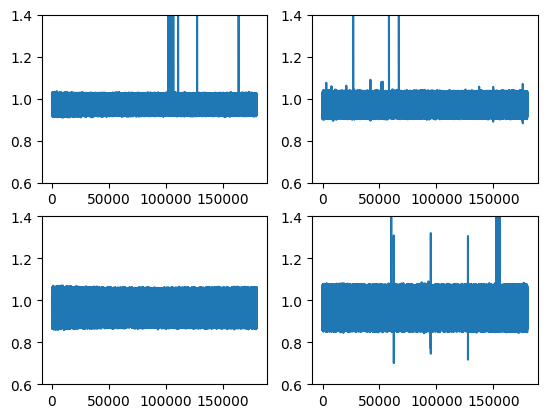

In [8]:
anomaly_data1 = 'data/anomaly_data/anomaly_3v_data1.csv'
anomaly_data2 = 'data/anomaly_data/anomaly_3v_data2.csv'
anomaly_data3 = 'data/anomaly_data/anomaly_5v_data1.csv'
anomaly_data4 = 'data/anomaly_data/anomaly_5v_data2.csv'
multiple_plotting(anomaly_data1, anomaly_data2, anomaly_data3, anomaly_data4)

<Figure size 2000x2000 with 0 Axes>

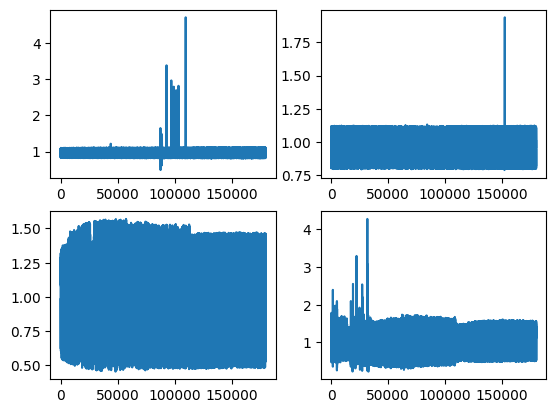

In [13]:
anomaly_data1 = 'data/anomaly_data/anomaly_7v_data1.csv'
anomaly_data2 = 'data/anomaly_data/anomaly_7v_data2.csv'
anomaly_data3 = 'data/anomaly_data/anomaly_contact_9v_data1.csv'
anomaly_data4 = 'data/anomaly_data/anomaly_contact_12v_data1.csv'
multiple_plotting(anomaly_data1, anomaly_data2, anomaly_data3, anomaly_data4)

<Figure size 2000x2000 with 0 Axes>

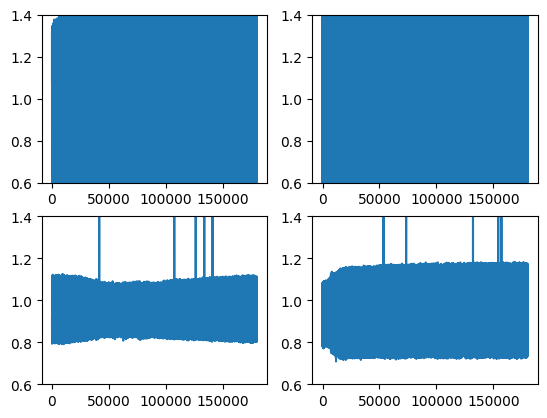

In [18]:

anomaly_data1 = 'data/anomaly_data/anomaly_contact_9v_data1.csv'
anomaly_data2 = 'data/anomaly_data/anomaly_contact_12v_data1.csv'
anomaly_data3 = 'data/anomaly_data/anomaly_unbalanced_9v_data1.csv'
anomaly_data4 = 'data/anomaly_data/anomaly_unbalanced_12v_data1.csv'
multiple_plotting(anomaly_data1, anomaly_data2, anomaly_data3, anomaly_data4)

### Anomaly dataset prepration

In [11]:
import os

folder_path = 'data/anomaly_data'

anomaly_data_path = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]

print(anomaly_data_path)


['data/anomaly_data\\anomaly_3v_data1.csv', 'data/anomaly_data\\anomaly_3v_data2.csv', 'data/anomaly_data\\anomaly_5v_data1.csv', 'data/anomaly_data\\anomaly_5v_data2.csv', 'data/anomaly_data\\anomaly_7v_data1.csv', 'data/anomaly_data\\anomaly_7v_data2.csv', 'data/anomaly_data\\anomaly_contact_12v_data1.csv', 'data/anomaly_data\\anomaly_contact_9v_data1.csv', 'data/anomaly_data\\anomaly_unbalanced_12v_data1.csv', 'data/anomaly_data\\anomaly_unbalanced_9v_data1.csv']


### Test with just anomaly data

In [12]:
all_anomaly_test_data = []
for data in anomaly_data_path:
    df = pd.read_csv(data)
    df = df[:len(df) - (len(df) % 100)]
    all_anomaly_test_data.append(df.values.reshape(-1, 100, 3))
    # print(df.shape)

# all_anomaly_test_data = np.concatenate(all_anomaly_test_data, axis=0)
for i in range(len(all_anomaly_test_data)):
    print(all_anomaly_test_data[i].shape)


(1800, 100, 3)
(1800, 100, 3)
(1800, 100, 3)
(1800, 100, 3)
(1799, 100, 3)
(1800, 100, 3)
(1799, 100, 3)
(1799, 100, 3)
(1800, 100, 3)
(1800, 100, 3)


In [4]:
import tensorflow as tf
print(tf.__version__)


2.3.0


In [111]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

autoencoder = load_model("autoencoder.h5")

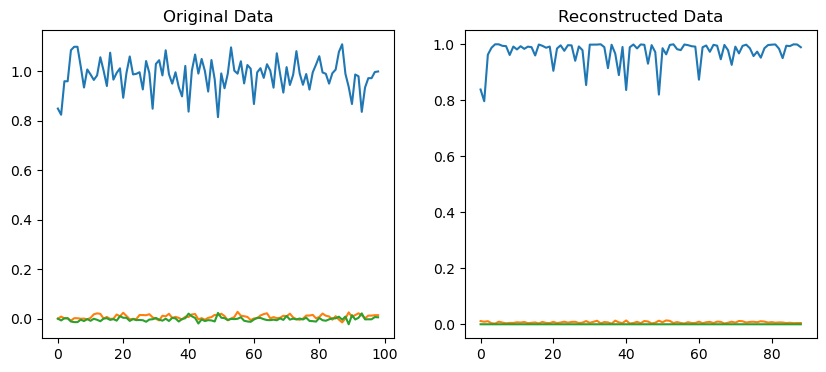

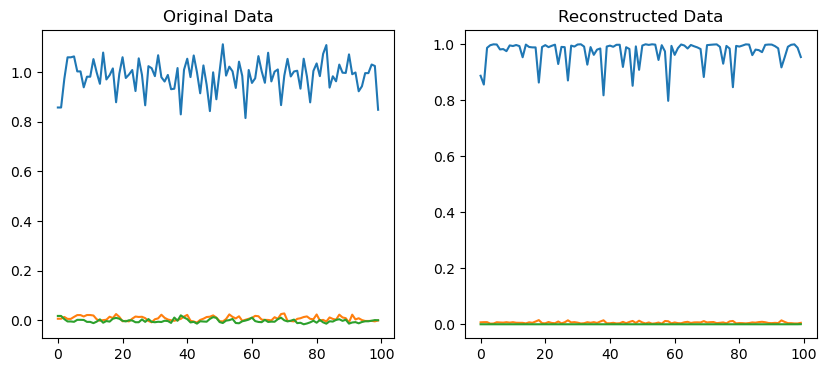

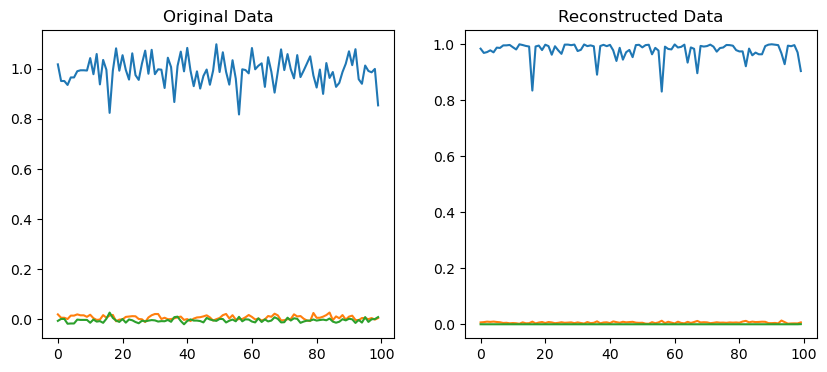

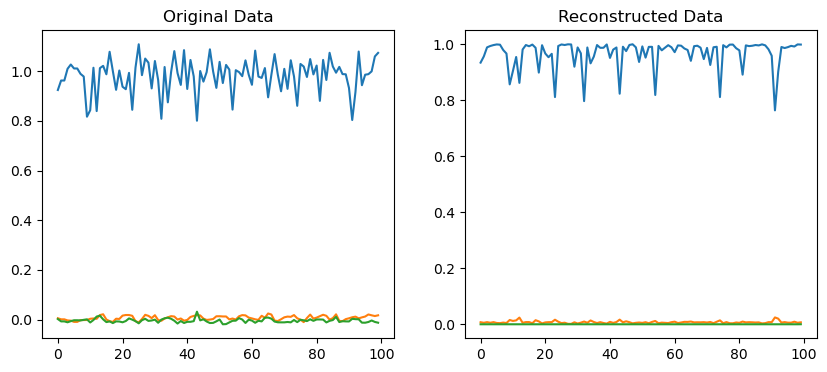

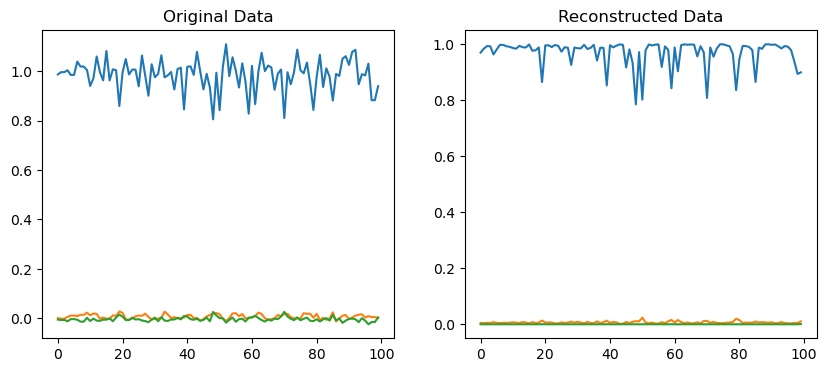

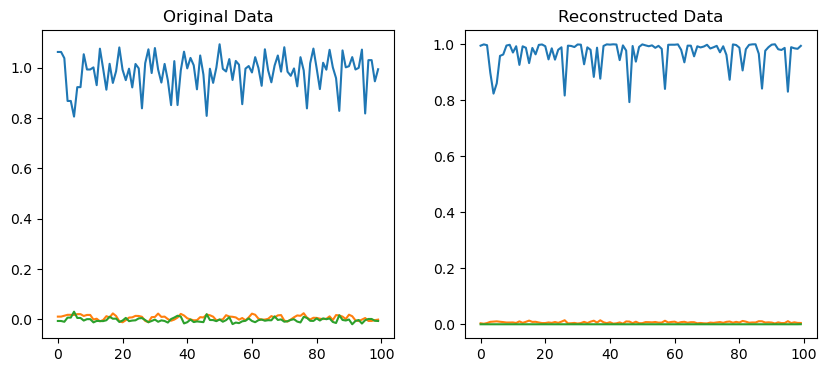

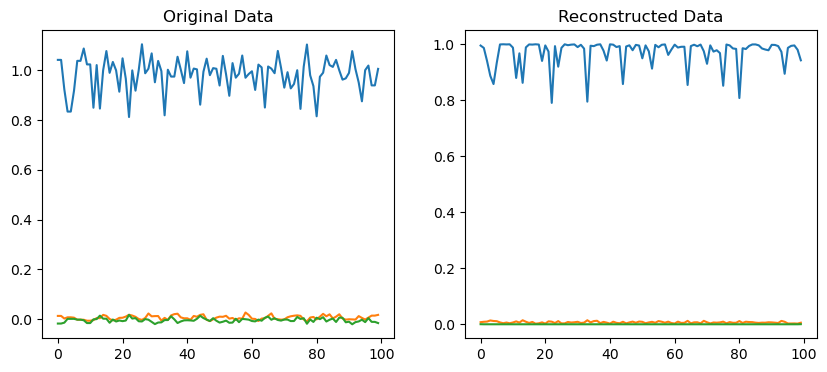

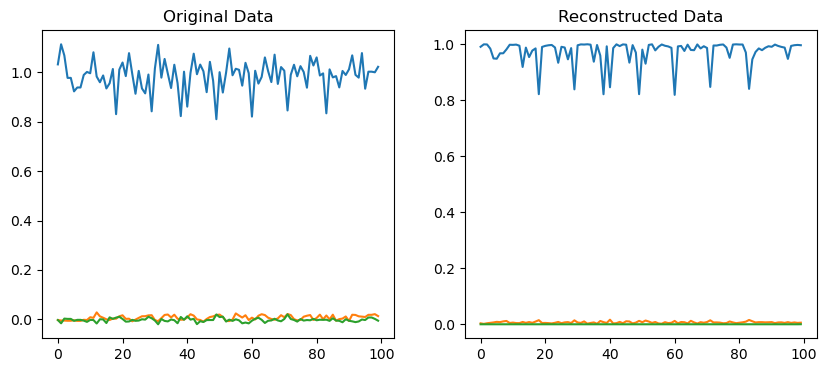

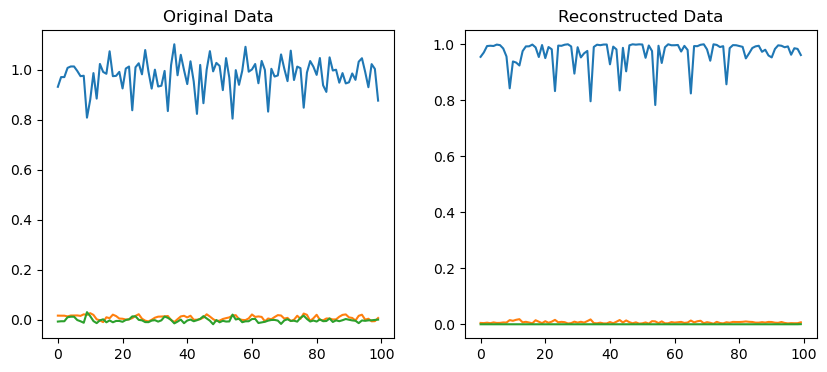

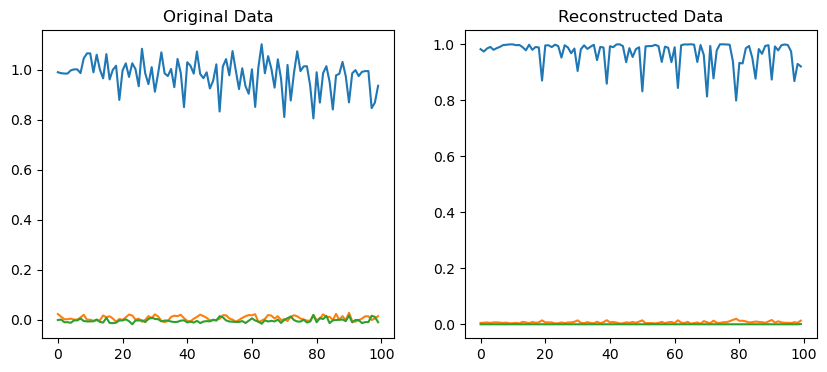

In [149]:
# 비정상 데이터 확인
reconstructed_data = autoencoder.predict(all_anomaly_test_data[-1])

# 4. 결과 분석
# 원본 데이터와 재구성된 데이터 비교
for i in range(10):  # 첫 5개 샘플만 비교
    plt.figure(figsize=(10, 4))
    
    # 원본 데이터
    plt.subplot(1, 2, 1)
    plt.title("Original Data")
    plt.plot(all_anomaly_test_data[-1][-i-1].reshape(-1, 3))  # 데이터를 2D로 변형하여 시각화
    
    # 재구성된 데이터
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Data")
    plt.plot(reconstructed_data[-i-1].reshape(-1, 3))  # 데이터를 2D로 변형하여 시각화

    plt.show()

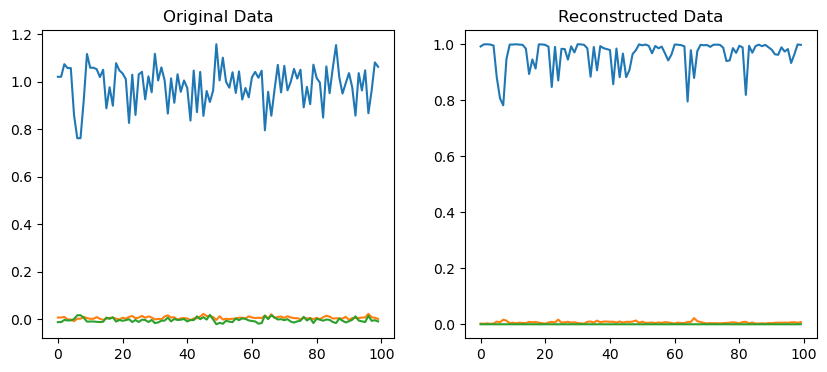

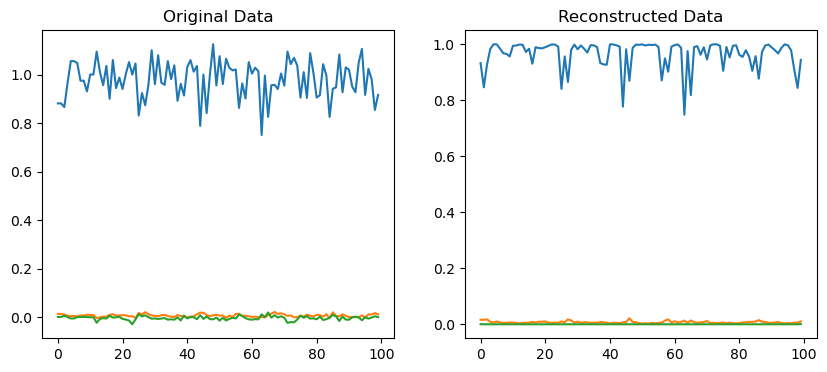

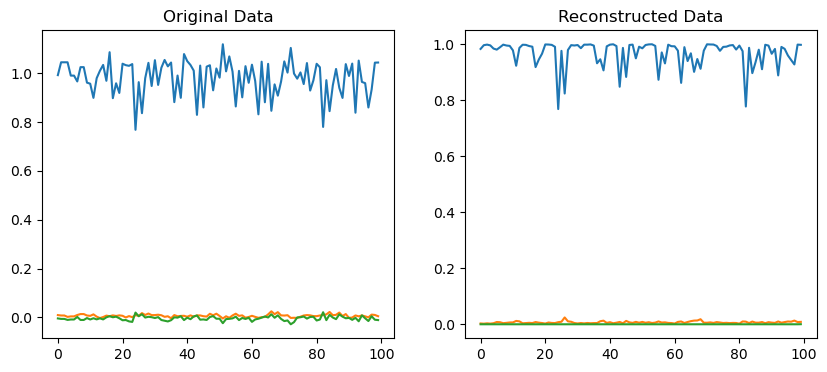

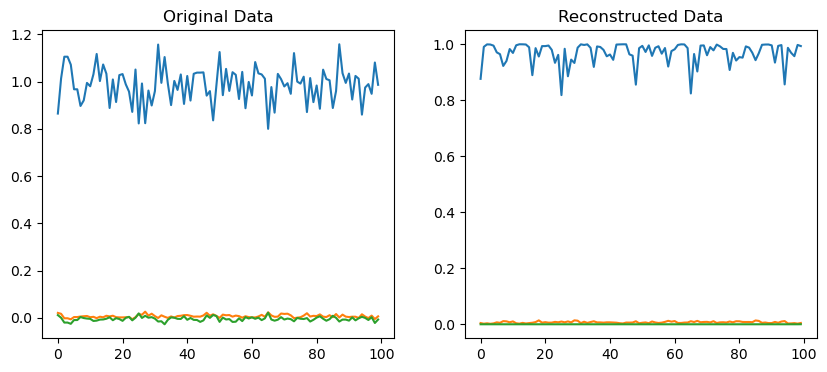

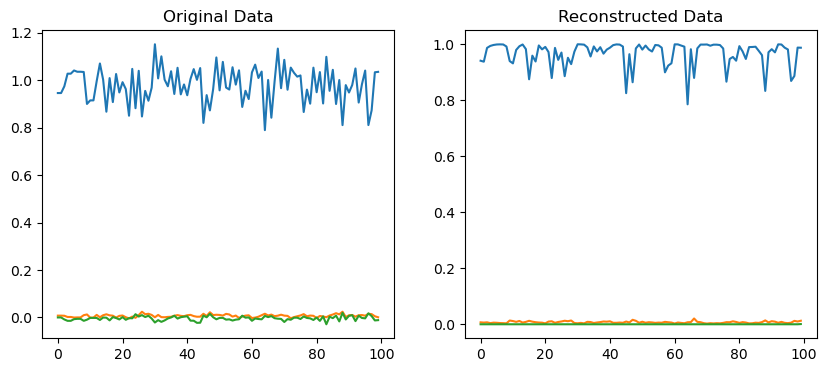

In [150]:
# 정상 데이터 확인
reconstructed_data = autoencoder.predict(x_test_concat)
reconstruction_error = np.mean(np.square(x_test_concat - reconstructed_data), axis=1)
# 4. 결과 분석
# 원본 데이터와 재구성된 데이터 비교
for i in range(5):  # 첫 5개 샘플만 비교
    plt.figure(figsize=(10, 4))
    
    # 원본 데이터
    plt.subplot(1, 2, 1)
    plt.title("Original Data")
    plt.plot(x_test_concat[i].reshape(-1, 3))  # 데이터를 2D로 변형하여 시각화
    
    # 재구성된 데이터
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Data")
    plt.plot(reconstructed_data[i].reshape(-1, 3))  # 데이터를 2D로 변형하여 시각화

    plt.show()

In [151]:
reconstructed_data = autoencoder.predict(x_test_concat)
reconstruction_error = np.mean(np.square(x_test_concat - reconstructed_data), axis=1)



print(np.isnan(reconstruction_error).any())  # True면 NaN이 포함되어 있음
nan_count = np.sum(np.isnan(reconstruction_error)) 
reconstruction_error = np.nan_to_num(reconstruction_error)

mean_error = np.mean(reconstruction_error)
std_error = np.std(reconstruction_error)

print(mean_error, std_error)

# threshold = mean_error + 2 * std_error  # 예시: 평균 + 2 표준편차

# mean_error = np.mean(reconstruction_error)
# std_error = np.std(reconstruction_error)
# threshold = mean_error + 2 * std_error  # 예시: 평균 + 2 표준편차

threshold = np.percentile(reconstruction_error, 95) 
# print(threshold)
is_anomaly_x = reconstruction_error[:, 0] > threshold  # x축
is_anomaly_y = reconstruction_error[:, 1] > threshold  # y축
is_anomaly_z = reconstruction_error[:, 2] > threshold  # z축


# is_anomaly = reconstruction_error > threshold
is_anomaly = is_anomaly_x 

anomaly_count = np.sum(is_anomaly)  # True의 개수
normal_count = len(is_anomaly) - anomaly_count  # False의 개수

# 비율 계산
total_count = len(is_anomaly)
anomaly_ratio = anomaly_count / total_count
normal_ratio = normal_count / total_count

print(f'어노말리 비율: {anomaly_ratio:.2%}')
print(f'정상 비율: {normal_ratio:.2%}')

True
0.0019767171913833816 0.0037745147912620815
어노말리 비율: 14.99%
정상 비율: 85.01%


(1081, 3)


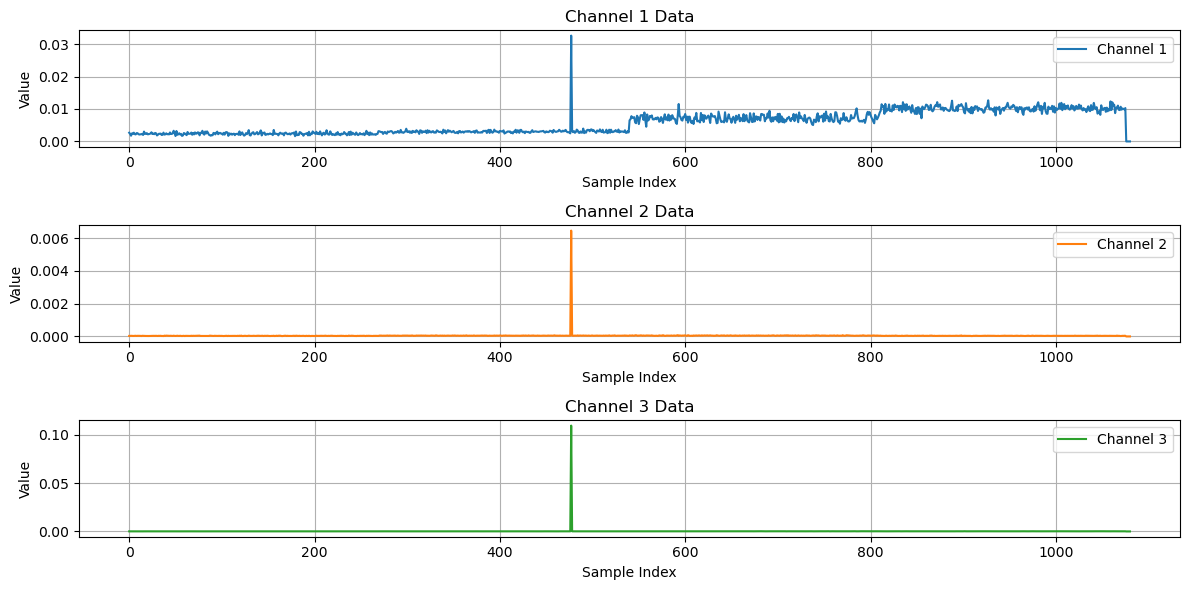

In [152]:
# 정상 데이터 reconstruction error
print(reconstruction_error.shape)

plt.figure(figsize=(12, 6))

# 각 채널에 대해 서브플롯 생성
for i in range(3):
    plt.subplot(3, 1, i + 1)  # 3행 1열의 서브플롯 설정
    plt.plot(reconstruction_error[:, i], label=f'Channel {i + 1}', color=f'C{i}')  # 채널별 그래프
    plt.title(f'Channel {i + 1} Data')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()

plt.tight_layout()  # 서브플롯 간격 조정
plt.show()

In [77]:
reconstructed_data = autoencoder.predict(all_anomaly_test_data[-1])
reconstruction_error = np.mean(np.square(all_anomaly_test_data[-1] - reconstructed_data), axis=1)

mean_error = np.mean(reconstruction_error)
std_error = np.std(reconstruction_error)
threshold = mean_error + 2 * std_error  # 예시: 평균 + 2 표준편차
threshold = np.percentile(reconstruction_error, 70) 

is_anomaly = reconstruction_error > threshold
print(is_anomaly)

anomaly_count = np.sum(is_anomaly)  # True의 개수
normal_count = len(is_anomaly) - anomaly_count  # False의 개수

# 비율 계산
total_count = len(is_anomaly)
anomaly_ratio = anomaly_count / total_count
normal_ratio = normal_count / total_count

print(f'어노말리 비율: {anomaly_ratio:.2%}')
print(f'정상 비율: {normal_ratio:.2%}')

[[False False False]
 [False False False]
 [False False False]
 ...
 [False False False]
 [False False False]
 [False False False]]
어노말리 비율: 0.00%
정상 비율: 100.00%


In [115]:
reconstructed_train_data = model.predict(x_train_concat)
reconstruction_error_train = np.mean(np.square(x_train_concat - reconstructed_train_data), axis=1)

threshold = np.percentile(reconstruction_error_train, 95)

print(threshold)

0.25549716585345333


0.0019767171913833816 0.0037745147912620815
False
NaN의 개수: 0
어노말리 비율: 0.06%
정상 비율: 99.94%



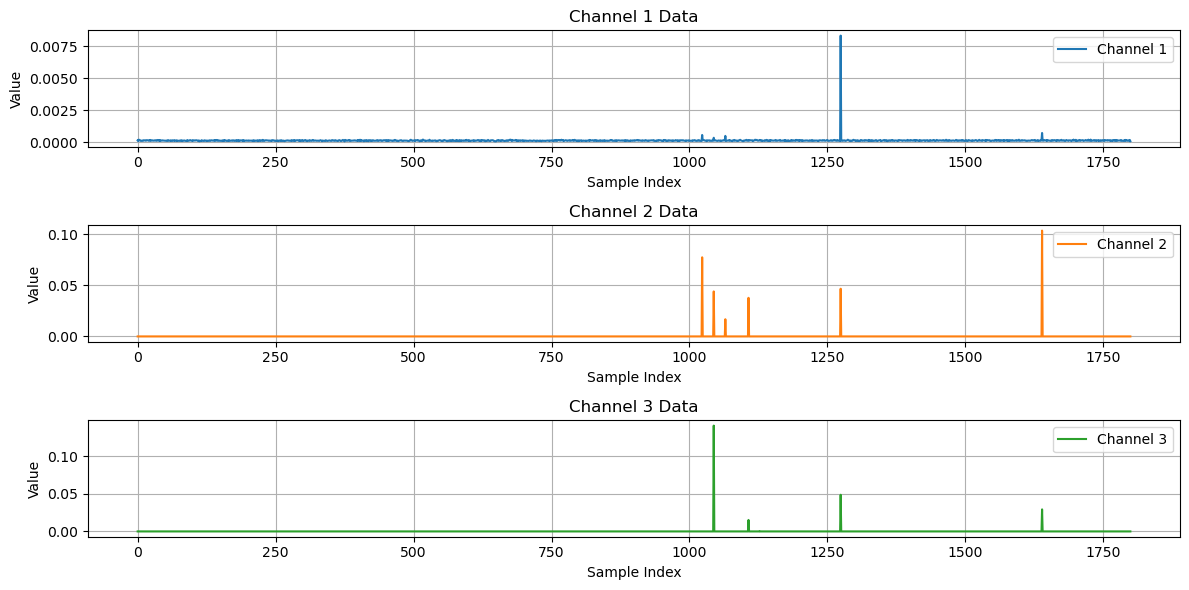

0.000161448694234028 0.0029117901939348643
False
NaN의 개수: 0
어노말리 비율: 0.06%
정상 비율: 99.94%



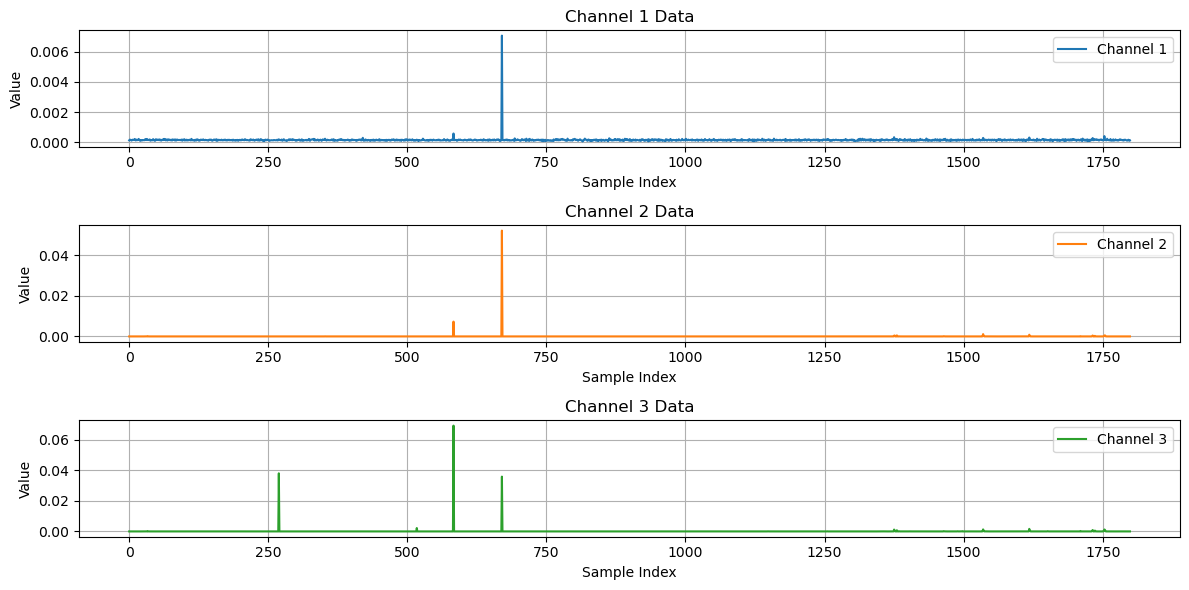

0.00010742630014032107 0.0013868686275227582
False
NaN의 개수: 0
어노말리 비율: 5.39%
정상 비율: 94.61%



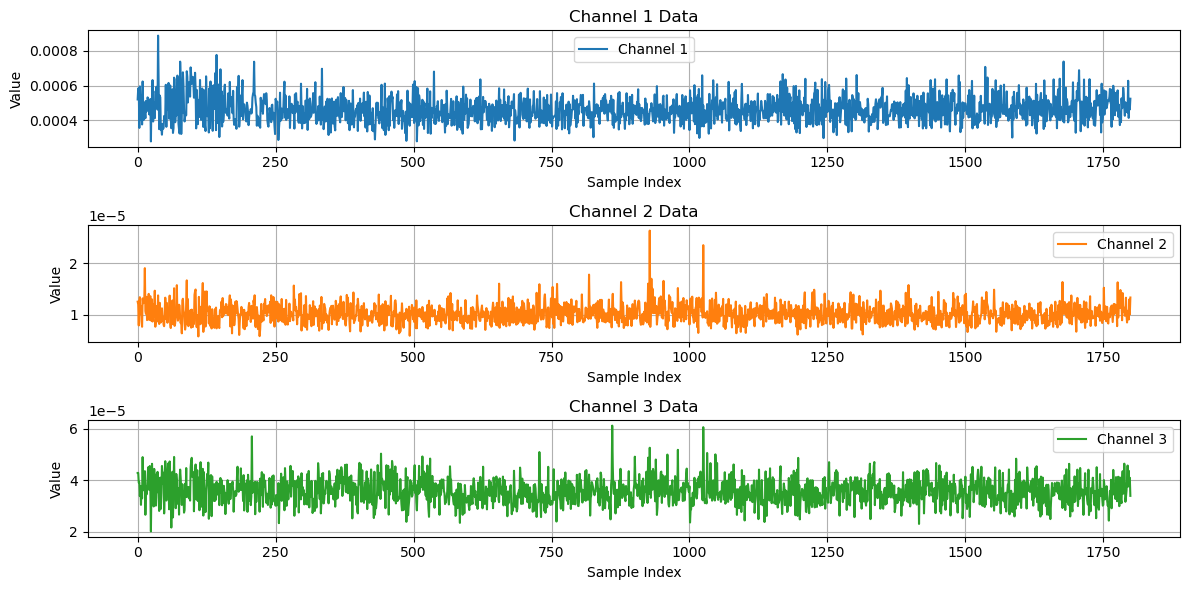

0.0001701271767217334 0.00021281645014890226
False
NaN의 개수: 0
어노말리 비율: 0.06%
정상 비율: 99.94%



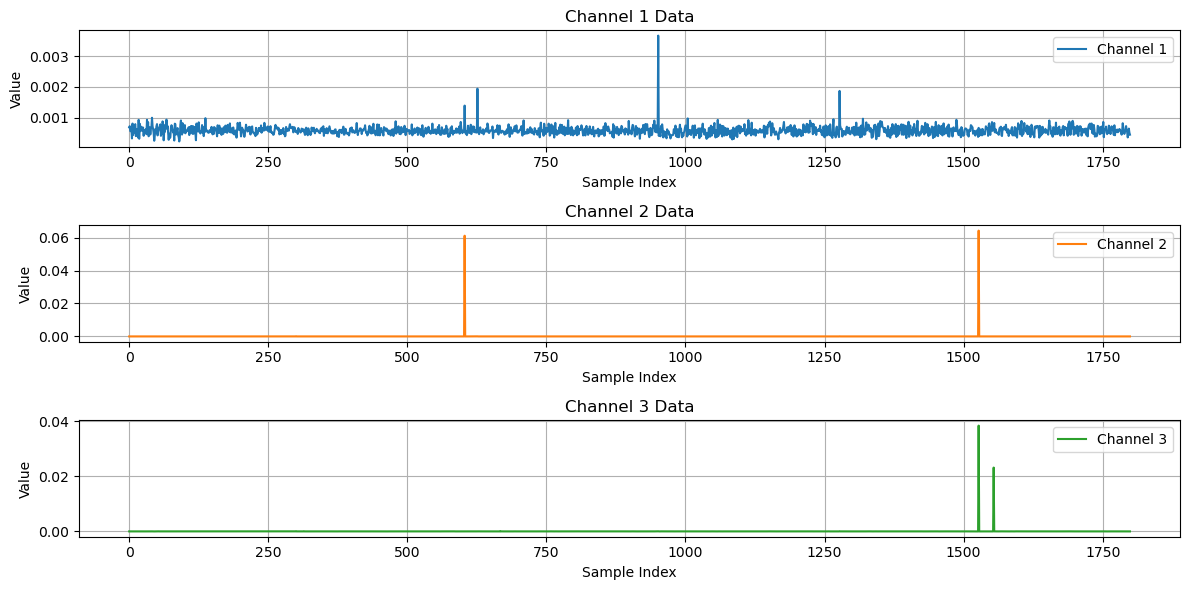

0.000240856847138468 0.0013754194911016848
False
NaN의 개수: 0
어노말리 비율: 0.11%
정상 비율: 99.89%



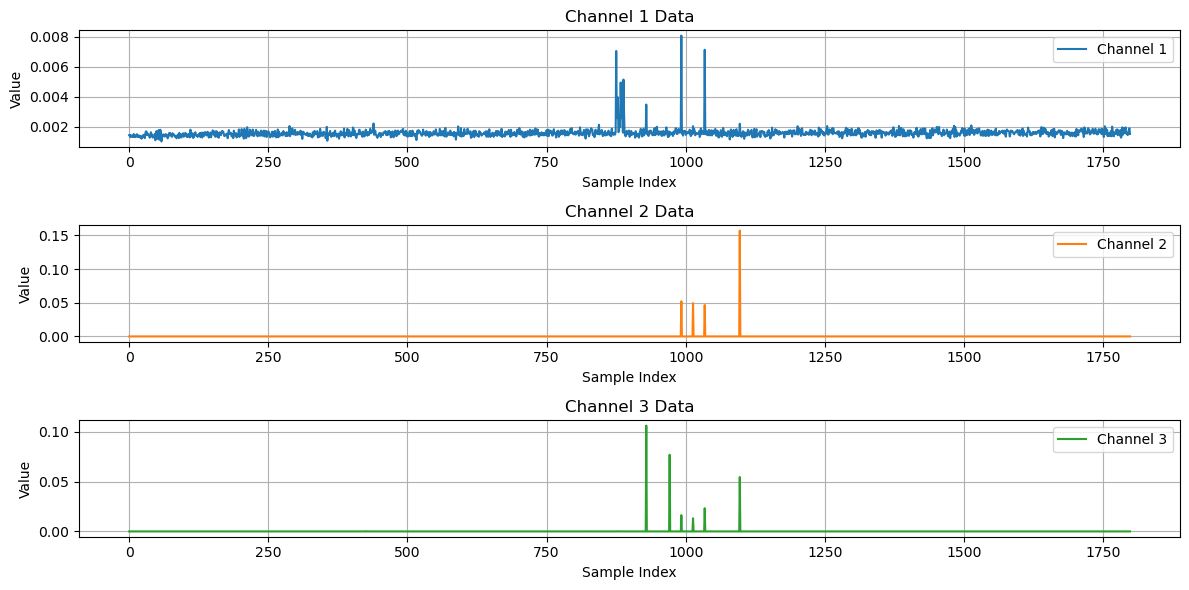

0.0006614669409380442 0.0032076350302301594
False
NaN의 개수: 0
어노말리 비율: 0.61%
정상 비율: 99.39%



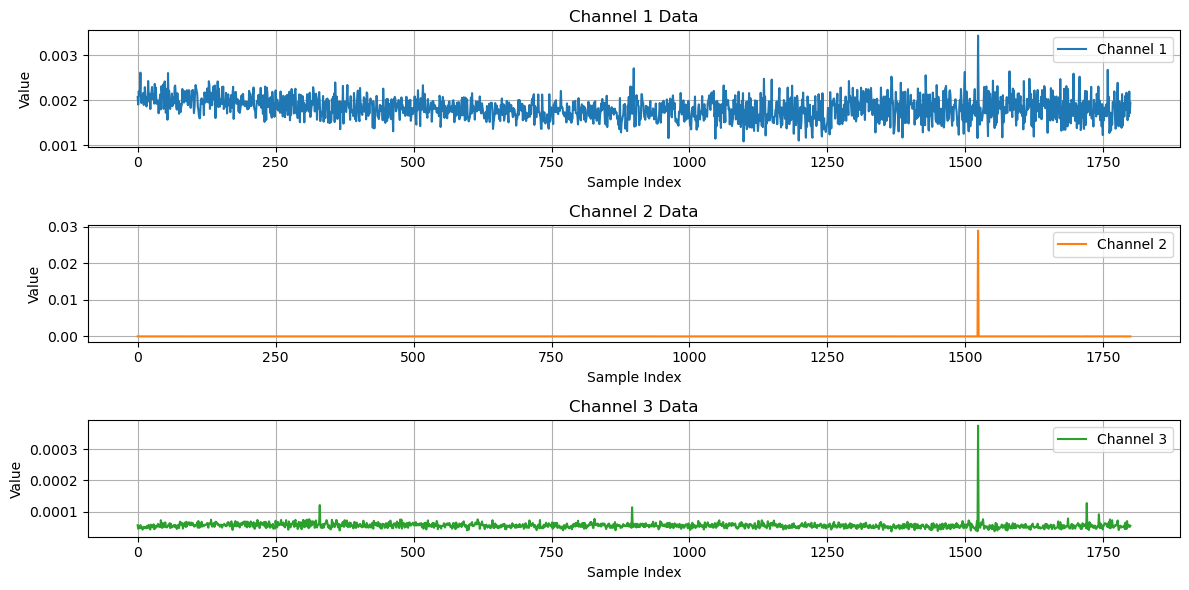

0.000637198982217752 0.0009395186665579832
False
NaN의 개수: 0
어노말리 비율: 10.17%
정상 비율: 89.83%



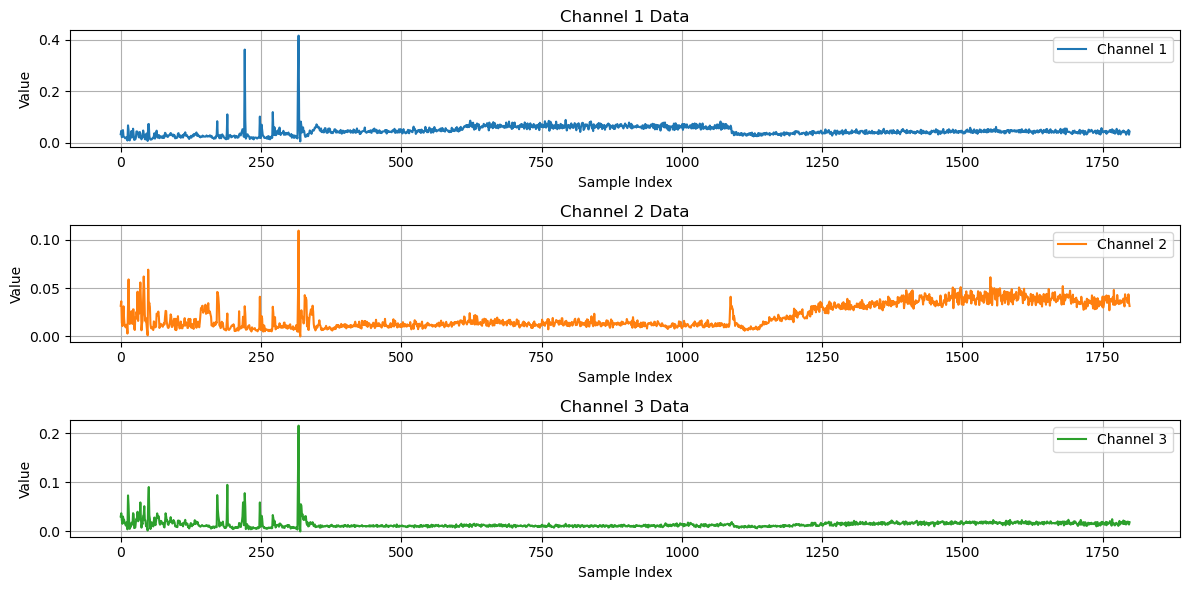

0.027127619396448255 0.019720200473028027
False
NaN의 개수: 0
어노말리 비율: 0.78%
정상 비율: 99.22%



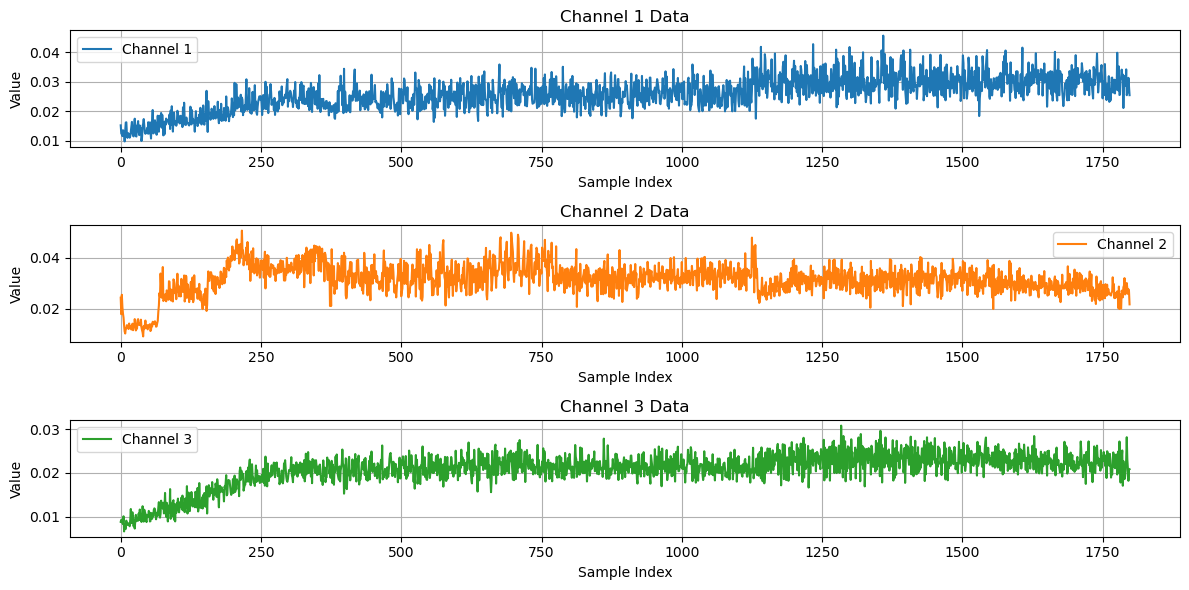

0.026088056287337666 0.006796761593673634
False
NaN의 개수: 0
어노말리 비율: 0.11%
정상 비율: 99.89%



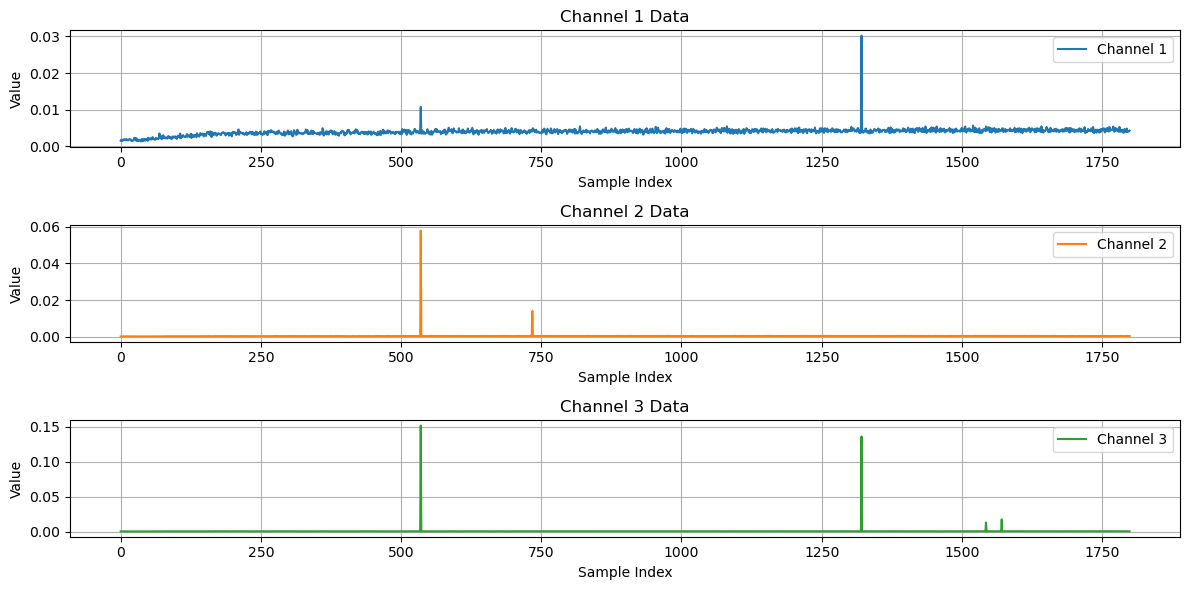

0.0015994445876588864 0.0033801256291500193
True
NaN의 개수: 3
어노말리 비율: 0.06%
정상 비율: 99.94%



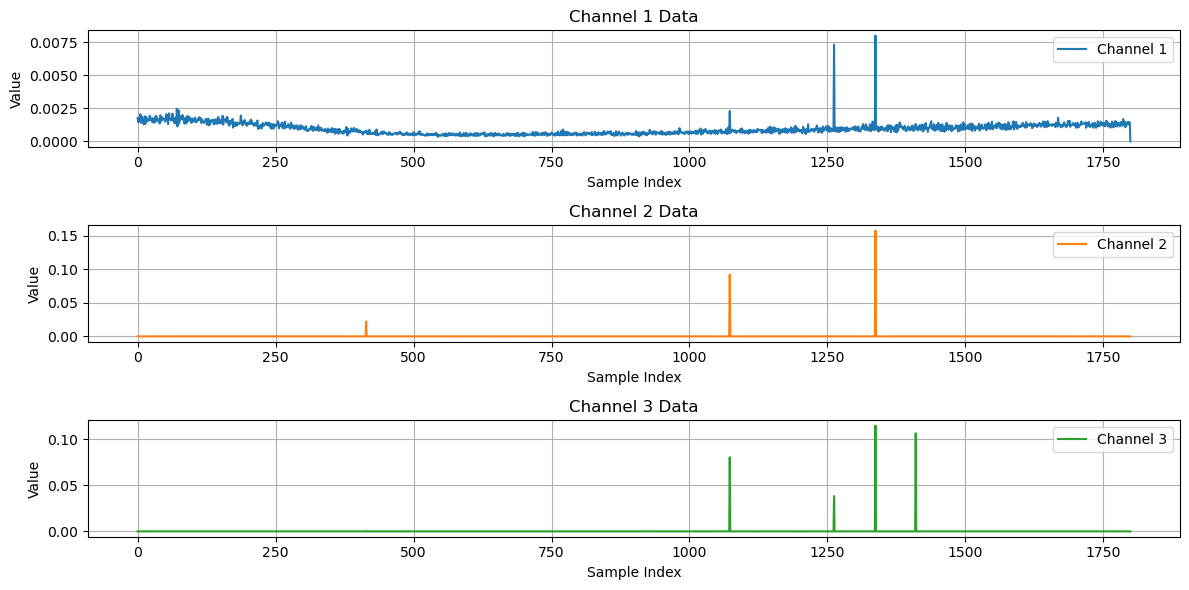

In [153]:
thresholds = []
for i in range(len(all_anomaly_test_data)):
    # print(all_anomaly_test_data[i].shape)
    # print(i)
    reconstructed_data = autoencoder.predict(all_anomaly_test_data[i])

    # print(reconstructed_data.shape)
    # print()
    reconstruction_error = np.mean(np.square(all_anomaly_test_data[i] - reconstructed_data), axis=1)
    # print(reconstruction_error.shape)
    # print()

    print(mean_error, std_error)
    print(np.isnan(reconstruction_error).any())  # True면 NaN이 포함되어 있음
    nan_count = np.sum(np.isnan(reconstruction_error))  # NaN의 개수
    print(f'NaN의 개수: {nan_count}')
    reconstruction_error = np.nan_to_num(reconstruction_error)

    # threshold
    threshold = np.percentile(reconstruction_error, 64)  # 95번째 백분위수
    thresholds.append(threshold)

    mean_error = np.mean(reconstruction_error)
    std_error = np.std(reconstruction_error)
    threshold = mean_error + 2 * std_error  # 예시: 평균 + 2 표준편차
    # print(threshold)
    is_anomaly_x = reconstruction_error[:, 0] > threshold  # x축
    is_anomaly_y = reconstruction_error[:, 1] > threshold  # y축
    is_anomaly_z = reconstruction_error[:, 2] > threshold  # z축

    # 각 축 중 하나라도 True인 경우, 전체 데이터 포인트를 이상으로 판단
    # is_anomaly = is_anomaly_x | is_anomaly_y | is_anomaly_z  # (1800,)
    is_anomaly = is_anomaly_x 

    # print(is_anomaly.shape) 

    # is_anomaly = reconstruction_error > threshold
    # print(is_anomaly.shape)

    # unique, counts = np.unique(is_anomaly, return_counts=True)
    # print(unique, counts)

    # # 결과 출력
    # anomaly_count = counts[1] if True in unique else 0  # True의 개수
    # normal_count = counts[0] if False in unique else 0  # False의 개수

    # print(f'어노말리 개수: {anomaly_count}')
    # print(f'정상 개수: {normal_count}')
    
    anomaly_count = np.sum(is_anomaly)  # True의 개수
    normal_count = len(is_anomaly) - anomaly_count  # False의 개수

    # # 비율 계산
    total_count = len(is_anomaly)
    anomaly_ratio = anomaly_count / total_count
    normal_ratio = normal_count / total_count

    print(f'어노말리 비율: {anomaly_ratio:.2%}')
    print(f'정상 비율: {normal_ratio:.2%}')

    # print()
    # print(len(is_anomaly), anomaly_count, normal_count, len(all_anomaly_test_data[i]))

    print()

    plt.figure(figsize=(12, 6))

    # 각 채널에 대해 서브플롯 생성
    for i in range(3):
        plt.subplot(3, 1, i + 1)  # 3행 1열의 서브플롯 설정
        plt.plot(reconstruction_error[:, i], label=f'Channel {i + 1}', color=f'C{i}')  # 채널별 그래프
        plt.title(f'Channel {i + 1} Data')
        plt.xlabel('Sample Index')
        plt.ylabel('Value')
        plt.legend()
        plt.grid()

    plt.tight_layout()  # 서브플롯 간격 조정
    plt.show()

In [134]:
thresholds.sort()
thresholds

[3.832270737187668e-05,
 3.892730548185406e-05,
 4.2250423123683725e-05,
 4.767683198780388e-05,
 6.627507392953763e-05,
 6.721019841727373e-05,
 0.00010072665612422799,
 0.00042425265355872235,
 0.02995205702815639,
 0.03367608058045493]

In [123]:
threshold = thresholds[0]

In [128]:

for i in range(len(all_anomaly_test_data)):

    reconstructed_data = autoencoder.predict(all_anomaly_test_data[i])
    reconstruction_error = np.mean(np.square(all_anomaly_test_data[i] - reconstructed_data), axis=1)

    # nan 제거
    print(np.isnan(reconstruction_error).any())  # True면 NaN이 포함되어 있음
    nan_count = np.sum(np.isnan(reconstruction_error))  # NaN의 개수
    reconstruction_error = np.nan_to_num(reconstruction_error)

    threshold = np.percentile(reconstruction_error, 64)  # 95번째 백분위수
    is_anomaly_x = reconstruction_error[:, 0] > threshold  # x축
    is_anomaly_y = reconstruction_error[:, 1] > threshold  # y축
    is_anomaly_z = reconstruction_error[:, 2] > threshold  # z축


    is_anomaly = is_anomaly_x | is_anomaly_y | is_anomaly_z  # (1800,)

    
    anomaly_count = np.sum(is_anomaly)  # True의 개수
    normal_count = len(is_anomaly) - anomaly_count  # False의 개수

    # # 비율 계산
    total_count = len(is_anomaly)
    anomaly_ratio = anomaly_count / total_count
    normal_ratio = normal_count / total_count

    print(f'어노말리 비율: {anomaly_ratio:.2%}')
    print(f'정상 비율: {normal_ratio:.2%}')
    print()

False
어노말리 비율: 100.00%
정상 비율: 0.00%

False
어노말리 비율: 100.00%
정상 비율: 0.00%

False
어노말리 비율: 100.00%
정상 비율: 0.00%

False
어노말리 비율: 100.00%
정상 비율: 0.00%

False
어노말리 비율: 100.00%
정상 비율: 0.00%

False
어노말리 비율: 100.00%
정상 비율: 0.00%

False
어노말리 비율: 84.21%
정상 비율: 15.79%

False
어노말리 비율: 78.43%
정상 비율: 21.57%

False
어노말리 비율: 100.00%
정상 비율: 0.00%

True
어노말리 비율: 99.94%
정상 비율: 0.06%



In [129]:
reconstructed_data = autoencoder.predict(x_test_concat)
reconstruction_error = np.mean(np.square(x_test_concat - reconstructed_data), axis=1)

is_anomaly_x = reconstruction_error[:, 0] > threshold  # x축
is_anomaly_y = reconstruction_error[:, 1] > threshold  # y축
is_anomaly_z = reconstruction_error[:, 2] > threshold  # z축

threshold = np.percentile(reconstruction_error, 64)  # 95번째 백분위수
is_anomaly = is_anomaly_x | is_anomaly_y | is_anomaly_z  # (1800,)


anomaly_count = np.sum(is_anomaly)  # True의 개수
normal_count = len(is_anomaly) - anomaly_count  # False의 개수

# 비율 계산
total_count = len(is_anomaly)
anomaly_ratio = anomaly_count / total_count
normal_ratio = normal_count / total_count

print(f'어노말리 비율: {anomaly_ratio:.2%}')
print(f'정상 비율: {normal_ratio:.2%}')

어노말리 비율: 99.54%
정상 비율: 0.46%
